In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
import os
import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from torch_snippets import *
from pathlib import Path
from imutils import paths
from tqdm.auto import tqdm
import re
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
ORI_IMAGE_SIZE = 1024
TG_IMAGE_SIZE = 224

In [19]:
image_paths = list(paths.list_images('train'))
progress_bar = tqdm(total=len(image_paths), desc='Resizing images')

for image_path in image_paths:
    image_path = Path(image_path)
    image = Image.open(image_path)
    resized_image = image.resize((TG_IMAGE_SIZE, TG_IMAGE_SIZE))
    output_path = Path('train') / image_path.name
    
    resized_image.save(output_path)
    progress_bar.update(1)

progress_bar.close()

Resizing images:   0%|          | 0/3422 [00:00<?, ?it/s]

In [4]:
df = pd.read_csv('train.csv')
train_idx, val_idx = train_test_split(df.image_id.unique(), train_size=0.7, random_state=23)
train_df, val_df = df[df['image_id'].isin(train_idx)], df[df['image_id'].isin(val_idx)]
label2target = {'background': 0, 'wheat_head': 1}
target2label = {value: key for key, value in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [14]:
class WheatDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, isTest=None):
        super().__init__()
        self.w, self.h = TG_IMAGE_SIZE, TG_IMAGE_SIZE
        self.img_dir = img_dir
        self.annotations = df.copy()
        self.files = glob.glob(self.img_dir + '/*')
        self.transform = transform
        self.images = df.image_id.unique()
        self.isTest = isTest

    def __len__(self):
        return len(self.images)
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))
    
    def __getitem__(self, index):
        image_path = find(self.images[index], self.files)
        image = np.array(Image.open(image_path).convert('RGB'))
        # image /= 255
        if self.isTest is True:
            if self.transform:
                # image = np.array(image)
                augmentations = self.transform(image)
            
            return image

        data = self.annotations[self.annotations['image_id'] == self.images[index]]
        boxes = data.get('bbox').values.tolist()
        # list of strings to list of lists
        for i in range(len(boxes)):
            boxes[i] = eval(boxes[i])
        boxes = np.array(boxes)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes[:, [0, 2]] = boxes[:, [0, 2]] / ORI_IMAGE_SIZE * TG_IMAGE_SIZE
        boxes[:, [1, 3]] = boxes[:, [1, 3]] / ORI_IMAGE_SIZE * TG_IMAGE_SIZE
        # boxes = boxes.astype(np.uint32).tolist()
        label = ['wheat_head'] * len(data)   

        if self.transform:
            if len(boxes):
                augmentations = self.transform(image=image, bboxes=boxes)
                image = augmentations['image']
                boxes = augmentations['bboxes']
            else:
                augmentations = self.transform(image=image, bboxes=np.zeros((1, 4)))
                image = augmentations['image']
                boxes = augmentations['bboxes']
        
        target = {}
        target['boxes'] = torch.tensor(boxes).float()
        target['labels'] = torch.tensor([label2target[i] for i in label]).long()

        return image, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [15]:
train_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=int(TG_IMAGE_SIZE)),
        A.PadIfNeeded(
            min_height=int(TG_IMAGE_SIZE),
            min_width=int(TG_IMAGE_SIZE),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=TG_IMAGE_SIZE, height=TG_IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                # A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", min_visibility=0.4, label_fields=[],),
)
val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
],bbox_params=A.BboxParams(format="pascal_voc", min_visibility=0.4, label_fields=[],))

In [16]:
train_dataset = WheatDataset(train_df, 'train', train_transform)
val_dataset = WheatDataset(val_df, 'train', val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


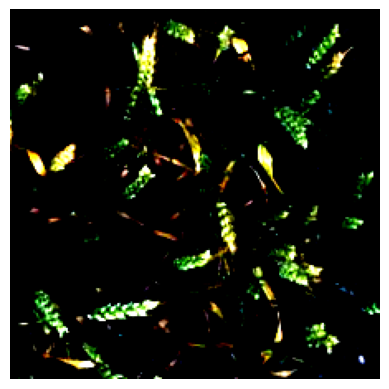

In [17]:
image, target = train_dataset[0]
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

In [18]:
target

{'boxes': tensor([[ 13.9801,  63.0556,  27.5058,  72.7203],
         [142.4471, 117.6667, 173.0914, 134.4116],
         [120.0055, 112.3304, 141.1967, 150.1236],
         [  0.0000,  34.7906,  25.8531,  61.8211],
         [176.3716,  21.8508, 207.4217,  51.5495],
         [ 63.6587,  90.8444,  93.4190, 119.0603],
         [193.4487, 124.5499, 213.0266, 136.9850],
         [ 47.7218,  74.7514,  77.0873,  95.0437],
         [109.5083,  82.8727, 127.0622, 103.1293],
         [172.8524,   5.4995, 204.8198,  38.8182],
         [203.4442, 110.4722, 215.0394, 122.0674],
         [158.3135,   5.4282, 186.8023,  27.3534],
         [ 88.3354,   2.2315, 115.5024,  25.7306],
         [ 17.8104,  78.1268,  47.0394, 102.3366],
         [ 74.3499,  17.8501,  91.0948,  48.4944],
         [155.7266,  54.1182, 184.8991,  74.6035],
         [ 95.3545, 143.7420, 123.5052, 161.4681],
         [151.2167, 136.4822, 178.5792, 156.5089],
         [174.0667, 193.9600, 203.7777, 208.6133],
         [ 38.2011, 13

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=train_dataset.collate_fn, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, collate_fn=val_dataset.collate_fn, drop_last=True)

In [20]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
num_epochs = 20

In [13]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad()
def validate_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [22]:
all_train_loss = []
all_val_loss = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for batch_idx, inputs in enumerate(tqdm(train_dataloader)):
        input, targets = inputs
        input = list(image.to(device) for image in input)
        targets = [{key: value.to(device) for key, value in target.items()} for target in targets]

        losses = model(input, targets)
        loss = sum(loss for loss in losses.values())
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    all_train_loss.append(train_loss)
    print(f"Train loss: {train_loss}")

    val_loss = 0
    for batch_idx, inputs in enumerate(tqdm(val_dataloader)):
        input, targets = inputs
        input = list(image.to(device) for image in input)
        targets = [{key: value.to(device) for key, value in target.items()} for target in targets]

        with torch.no_grad():
            optimizer.zero_grad()
            losses = model(input, targets)
            loss = sum(loss for loss in losses.values())
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    all_val_loss.append(val_loss)
    print(f"Val loss: {val_loss}")

# for epoch in range(num_epochs):
#     n = len(train_dataloader)
#     print(f"Epoch {epoch}")
#     print("Training phase: ")
#     for batch_idx, inputs in enumerate(train_dataloader):
#         loss, losses = train_batch(inputs, model, optimizer)
#         loc_losses, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
#         all_train_loss.append(loss.item())
#     print(f"Train loss: {loss.item()}")

#     n = len(val_dataloader)
#     print("Testing phase: ")
#     for batch_idx, inputs in enumerate(val_dataloader):
#         loss, losses = validate_batch(inputs, model, optimizer)
#         loc_losses, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
#         all_val_loss.append(loss.item())
#     print(f"Val loss: {loss.item()}")        

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).

In [33]:
new_train_loss = []
new_val_loss = []
for idx, train_loss in enumerate(all_train_loss):
    if idx % 590 == 0:
        new_train_loss.append(train_loss)

for idx, val_loss in enumerate(all_val_loss):
    if idx % 252 == 0:
        new_val_loss.append(val_loss)

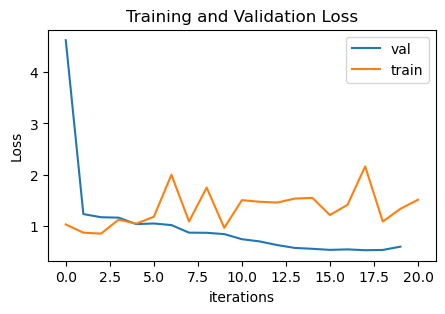

In [34]:
plt.figure(figsize=(5,3))
plt.title("Training and Validation Loss")
plt.plot(new_train_loss,label="val")
plt.plot(new_val_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [65]:
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    keep_idx = np.where(confs > 0.5)[0]
    bbs, confs, labels = [tensor[keep_idx] for tensor in [bbs, confs, labels]]
    ixs = torchvision.ops.nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

In [69]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [102]:
test_df = pd.read_csv('sample_submission.csv')
test_dataset = WheatDataset(test_df, 'test', test_transform, isTest=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=test_dataset.collate_fn, drop_last=True)

In [103]:
images = next(iter(test_dataloader))
images.shape

AttributeError: 'tuple' object has no attribute 'shape'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


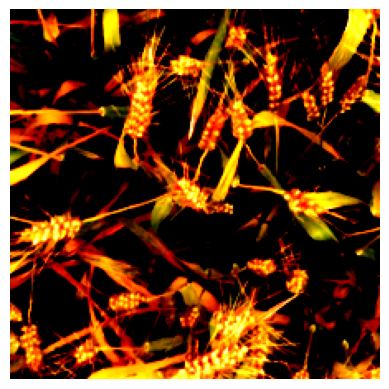

In [126]:
image = test_dataset[8]
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

In [127]:
image = image.unsqueeze(0).to(device)
image.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


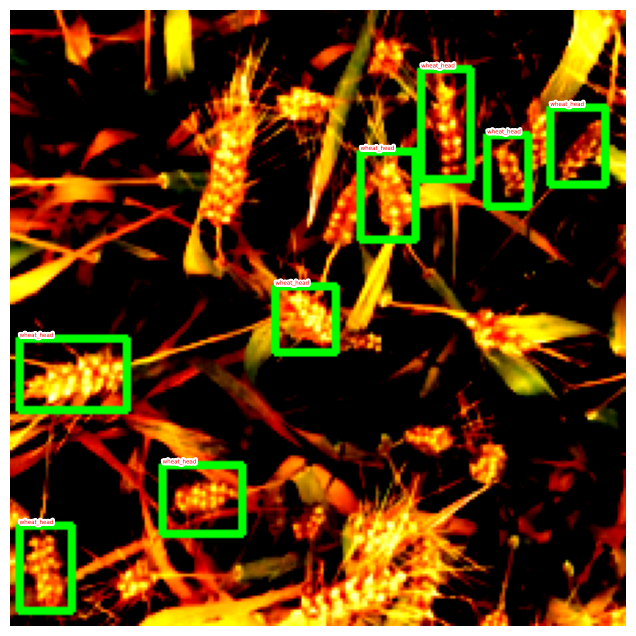

In [128]:
model.eval()
output = model(image)
for ix, output in enumerate(output):
    bbs, confs, labels = decode_output(output)
    info = [f'{l}@{c:.2f}' for l, c in zip(labels, confs)]
    show(image.squeeze(0).cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=8)

In [72]:
model.eval()
for ix, images in enumerate(test_dataloader):
    if ix == 1: break
    images = torch.tensor(images)
    input = list(image.to(device) for image in images)
    outputs = model(input)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l, c in zip(labels, confs)]
        show(images[ix].cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=8)

ValueError: only one element tensors can be converted to Python scalars